## Import all what we need.

In [1]:
import os
import time
#import pylab
import requests
import numpy as np
import pandas as pd
from tqdm import tqdm
from numba import jit
from io import StringIO
import matplotlib.pyplot as plt
import threading, multiprocessing

## The Input File Path and Parameters


<table><tr><td bgcolor=skyblue><font size=24> Could be changed ! </font></td></tr></table>

In [2]:
#########################################################
inp_filepath = 'CO2.inp'

ratio_air = 0.7
ratio_self = 0.3
cutoff = 25.0
threshold = 1e-30
P = 1.0
#########################################################

## Report time

In [3]:
class Timer:    
    def start(self):
        self.start_CPU = time.clock()
        self.start_sys = time.time()
        return self

    def end(self, *args):
        self.end_CPU = time.clock()
        self.end_sys = time.time()
        self.interval_CPU = self.end_CPU - self.start_CPU
        self.interval_sys = self.end_sys - self.start_sys
        print('{:25s} : {}'.format('Running time on CPU', self.interval_CPU), 's')
        print('{:25s} : {}'.format('Running time on system', self.interval_sys), 's')

## Read Information from Input File

In [4]:
def inp_para(inp_filepath):
    
    inp_col_name = ['c0', 'c1', 'c2']
    inp_df = pd.read_csv(inp_filepath, sep='\\s+', names=inp_col_name, header=None)
    col0 = inp_df['c0']
    database = inp_df[col0.isin(['Database'])]['c1'].values[0]
    molecule = inp_df[col0.isin(['Molecule'])]['c1'].values[0]
    isotopologue = inp_df[col0.isin(['Isotopologue'])]['c1'].values
    iso = int(inp_df[col0.isin(['iso'])]['c1'])
    T = float(inp_df[col0.isin(['Temperature'])]['c1'])
    min_wn = float(inp_df[col0.isin(['Range'])]['c1'])
    max_wn = float(inp_df[col0.isin(['Range'])]['c2'])
    N_point = int(inp_df[col0.isin(['Npoints'])]['c1'])
    profile = inp_df[col0.isin(['Profile'])]['c1'].values[0]
    wn_wl = inp_df[col0.isin(['Wavenumber(wn)/wavelength(wl)'])]['c1'].values[0]
    par_filepath = inp_df[col0.isin(['Transitions'])]['c1'].values[0]
    saveplots = inp_df[col0.isin(['SavePlots'])]['c1'].values[0]
    savexsecs = inp_df[col0.isin(['SaveXsecs'])]['c1'].values[0]

    molecule_id = int(iso/10)
    isotopologue_id = iso - molecule_id * 10
    isometa_url = 'https://hitran.org/docs/iso-meta/'
    iso_meta_table = pd.read_html(isometa_url)[molecule_id - 1]
    iso_meta_row = iso_meta_table[iso_meta_table['local ID'].isin([isotopologue_id])]
    abundance = float(iso_meta_row['Abundance'][0].replace('\xa0×\xa010','E'))
    mass = float(iso_meta_row['Molar Mass /g·mol-1'])
    Q_ref = float(iso_meta_row.loc[0][6].replace('\xa0×\xa010','E'))
    Q_url = 'https://hitran.org/data/Q/' + iso_meta_row.loc[0][7]
    Q_content = requests.get(Q_url).text
    Q_col_name = ['T', 'Q']
    Q_df = pd.read_csv(StringIO(Q_content), sep='\\s+', names=Q_col_name, header=None)
    Q = Q_df['Q'][T - 1]
    
    return database, molecule, T, min_wn, max_wn, N_point, profile, wn_wl, par_filepath, saveplots, savexsecs, molecule_id, isotopologue_id, abundance, mass, Q_ref, Q


## Constants and Parameters

In [5]:
# HITRAN Parameters for calculating.
import astropy.constants as ac
(database, molecule, T, min_wn, max_wn, N_point, profile, wn_wl, par_filepath, 
saveplots, savexsecs, molecule_id, isotopologue_id, abundance, mass, Q_ref, Q) = inp_para(inp_filepath)
T_ref = 296.0                   # Reference temperature is 296 K.
P_ref = 1.0                     # Reference pressure is 1 atm.
N_A = ac.N_A.value              # Avogadro number (mol^{-1})
h = ac.h.to('J s').value        # Planck's const (J s)
c = ac.c.to('cm/s').value       # Velocity of light (cm s^{-1})
kB = ac.k_B.to('J/K').value     # Boltzmann's const (J K^{-1})
c2 = h * c / kB                 # Second radiation constant (cm K)
c2_T = c2 / T                   # c2 / T (cm)
c2_T_ref = c2 / T_ref           # c2 / T_ref (cm)


## Read HITRAN Format Input File

Read the parameters of the molecular absorption features of HITRAN2016 format text file. Return the dataframe of the HITRAN data for the following calculations.

In [6]:
def read_hitran2016_parfile (par_filepath, parfile_df):
    '''
    Read the parameters of the molecular absorption features
    of HITRAN2016 format text file.
    
    Parameters
    ----------
    par_filepath : str
        Input file path for reading.
    Return
    ------
    hitran_df : DataFrame
        The DataFrame of HITRAN data for the molecule.
    '''    
    par_filename = par_filepath.split('/')[3]
    
    if not os.path.exists:
        raise ImportError('The input file ' + par_filename + ' does not exist.')

    if (len(str(parfile_df[0][0])) < 160):
        raise ImportError('The file ' + par_filename + ' is not a HITRAN2016 format data file.')
    #hitran_column_name = ['M','I','v','S','Acoeff','gamma_air','gamma_self',
    #                     'Epp','n_air','delta_air','Vp','Vpp','Qp','Qpp',
    #                     'Ierr','Iref','flag','gp','gpp']

    hitran_df = pd.DataFrame()

    #hitran_df['M'] = pd.to_numeric(parfile_df[0].map(lambda x: x[0:2]), errors='coerce').astype('int32')                # Molecule identification number
    hitran_df['I'] = pd.to_numeric(parfile_df[0].map(lambda x: x[2:3]), errors='coerce').astype('int32')                 # Isotopologue number
    hitran_df['v'] = pd.to_numeric(parfile_df[0].map(lambda x: x[3:15]), errors='coerce').astype('float64')              # Transition wavenumber (in cm^{-1})
    hitran_df['S'] = pd.to_numeric(parfile_df[0].map(lambda x: x[15:25]), errors='coerce').astype('float64')             # Intensity (cm^{-1} / (molecule cm^{-2}))
    hitran_df['Acoeff'] = pd.to_numeric(parfile_df[0].map(lambda x: x[25:35]), errors='coerce').astype('float64')        # Einstein A-coefficient (in s^{-1})
    hitran_df['gamma_air'] = pd.to_numeric(parfile_df[0].map(lambda x: x[35:40]), errors='coerce').astype('float64')     # Air-broadened half-width at half maximum (HWHM) coefficient (cm^{-1} atm^{-1})
    hitran_df['gamma_self'] = pd.to_numeric(parfile_df[0].map(lambda x: x[40:45]), errors='coerce').astype('float64')    # Self-broadened half-width at half maximum (HWHM) coefficient (cm^{-1} atm^{-1})
    hitran_df['Epp'] = pd.to_numeric(parfile_df[0].map(lambda x: x[45:55]), errors='coerce').astype('float64')           # Lower state energy (cm^{-1})
    hitran_df['n_air'] = pd.to_numeric(parfile_df[0].map(lambda x: x[55:59]), errors='coerce').astype('float64')         # Temperature-dependent exponent for gamma_air
    hitran_df['delta_air'] = pd.to_numeric(parfile_df[0].map(lambda x: x[59:67]), errors='coerce').astype('float64')     # Air pressure_include line shift (cm^{-1} atm^{-1})
    hitran_df['Vp'] = parfile_df[0].map(lambda x: x[67:82])                                                              # Upper-state "global" quanta
    hitran_df['Vpp'] = parfile_df[0].map(lambda x: x[82:97])                                                             # Lower-state "global" quanta
    hitran_df['Qp'] = parfile_df[0].map(lambda x: x[97:112])                                                             # Upper-state "local" quanta
    hitran_df['Qpp'] = parfile_df[0].map(lambda x: x[112:127])                                                           # Lower-state "local" quanta
    #hitran_df['Ierr'] = parfile_df[0].map(lambda x: x[127:133])                                                         # Uncertainty indices
    #hitran_df['Iref'] = parfile_df[0].map(lambda x: x[133:145])                                                         # Reference indices
    #hitran_df['flag'] = parfile_df[0].map(lambda x: x[145:146])                                                         # Flag
    hitran_df['gp'] = pd.to_numeric(parfile_df[0].map(lambda x: x[146:153]), errors='coerce').astype('float64')         # Statistical weight of the upper state
    #hitran_df['gpp'] = pd.to_numeric(parfile_df[0].map(lambda x: x[153:160]), errors='coerce').astype('float64')        # Statistical weight of the lower state

    hitran_df = hitran_df[hitran_df['I'].isin([isotopologue_id])]
    hitran_df = hitran_df[hitran_df['v'].between(min_wn, max_wn)]
    hitran_df = hitran_df[hitran_df['S'] > threshold]
    
    return hitran_df


In [7]:
def hitran_data_prepare(hitran_df):
    '''
    Read HITRAN .par file as the input file.
    Return the data for calculating wavennumbers and cross sections with line profiles.
    
    '''
    wn_grid = np.linspace(min_wn, max_wn, N_point)
    S = hitran_df['S'].values
    gp = hitran_df['gp'].values
    Epp = hitran_df['Epp'].values
    n_air = hitran_df['n_air'].values
    gamma_air = hitran_df['gamma_air'].values
    gamma_self = hitran_df['gamma_self'].values
    delta_air = hitran_df['delta_air'].values
    #v = hitran_df['v'].values + delta_air * (P - P_ref) / P
    v = hitran_df['v'].values
    
    return (wn_grid, S, gp, Epp, n_air, gamma_air, gamma_self, delta_air, v)

## Line Profile

In [168]:
@jit("(float64[:](float64[:], float64, float64))", nopython=True)
def Doppler_HWHM (v, mass, T):
    '''Return the Doppler half-width at half-maximum (HWHM) -- alpha.'''
    alpha = np.sqrt(2 * N_A * kB * T * np.log(2) / mass) * v / c
    return alpha

In [169]:
@jit("(float64[:](float64, float64, float64[:], float64[:], float64[:], float64[:]))", nopython=True)
def Lorentzian_HWHM (T, P, n_air, gamma_air, gamma_self, delta_air):
    '''Return the Lorentzian half-width at half-maximum (HWHM) -- gamma.'''
    #gamma = (gamma_air * ratio_air + gamma_self * ratio_self) * ((T_ref / T)**n_air) * (P / P_ref)
    gamma = (gamma_air * (P - delta_air) / P_ref + gamma_self * delta_air / P_ref) * (T_ref / T)**n_air * (P / P_ref)
    
    return gamma

In [170]:
@jit("float64[:](float64[:], float64[:])", nopython=True)
def Gaussian_profile(dv, alpha):
    '''Return Gaussian line profile at dv with HWHM alpha.'''
    Gaussian_profile = np.sqrt(np.log(2) / np.pi) / alpha * np.exp(-np.log(2) * (dv / alpha)**2)
    return Gaussian_profile

In [171]:
@jit("(float64[:](float64[:], float64[:]))", nopython=True)
def Lorentzian_profile(dv, gamma):
    '''Return Lorentzian line profile at dv with HWHM gamma.'''
    Lorentzian_profile = gamma / np.pi / (dv**2 + gamma**2)
    return Lorentzian_profile


In [172]:
def scipy_Voigt_profile(dv, alpha, gamma):
    '''Return the Voigt line profile with Gaussian component HWHM alpha and Lorentzian component HWHM gamma.'''
    from scipy.special import voigt_profile
    return voigt_profile(dv, alpha, gamma)

In [173]:
def scipy_wofz_Voigt_profile(dv, alpha, gamma):
    '''Return the Voigt line profile with Gaussian component HWHM alpha and Lorentzian component HWHM gamma.'''
    from scipy.special import wofz
    sigma = alpha / np.sqrt(2 * np.log(2))
    scipy_wofz_Voigt_profile = np.real(wofz((dv + 1j*gamma)/sigma/np.sqrt(2))) / sigma / np.sqrt(2*np.pi)
    return scipy_wofz_Voigt_profile

In [174]:
@jit("(float64[:](float64[:], float64[:], float64[:]))", nopython=True)
def width_Voigt_profile(dv, f_G, f_L):
    '''
    Return the full width at half maximum (FWHM) of the Voigt profile which can
    be found from the widths of the associated Gaussian and Lorentzian widths.

    '''
    width_Voigt_profile = 0.5346 * f_L + np.sqrt(0.2166 * f_L**2 + f_G**2)
    return width_Voigt_profile

In [175]:
@jit("(float64[:](float64[:], float64[:], float64[:]))", nopython=True)
def pseudo_Voigt_profile(dv, f_G, f_L):
    '''Return the Voigt line profile with Gaussian component HWHM alpha and Lorentzian component HWHM gamma.'''
    pseudo_Voigt_profile = (f_G**5+2.69269*f_G**4*f_L+2.42843*f_G**3*f_L**2+4.47163*f_G**2*f_L**3+0.07842*f_G*f_L**4+f_L**5)**0.2
    return pseudo_Voigt_profile

In [176]:
@jit("(float64[:](float64[:], float64[:], float64[:]))", nopython=True)
def pseudo_FWHM_Voigt_profile(dv, alpha, gamma):
    '''
    Return the Voigt line profile with Gaussian component HWHM alpha and Lorentzian component HWHM gamma.
    f is the total FWHM parameter.
    n is a function of Gaussian (f_G)，Lorentz (f_L) and total (f) full width at half maximum (FWHM) parameters.
    
    '''
    f_G = 2 * alpha * np.sqrt(2 * np.log(2))
    f_L = 2 * gamma
    f = (f_G**5 + 2.69269*f_G**4*f_L + 2.42843*f_G**3*f_L**2 + 4.47163*f_G**2*f_L**3 + 0.07842*f_G*f_L**4 + f_L**5)**0.2
    n = 1.36603*(f_L/f) - 0.47719*(f_L/f)**2 + 0.11116*(f_L/f)**3
    pseudo_fwhm_Voigt_profile = n*Lorentzian_profile(dv,f/2) + (1-n)*Gaussian_profile(dv,f/2)
    return pseudo_fwhm_Voigt_profile

## Calculate Cross Sections

In [177]:
@jit("(float64[:](float64[:], float64[:], float64, float64[:], float64, float64, float64, float64))", nopython=True)
def cal_abscoefs(v, S, abundance, Epp, T, T_ref, Q, Q_ref):
    abscoef = S * abundance * Q_ref / Q * np.exp(c2 * Epp * (1/T_ref - 1/T)) * (1 - np.exp(-c2_T * v)) / (1 - np.exp(-c2_T_ref * v))
    return (abscoef)

In [178]:
def hitran_cross_section_Gaussian(wn_grid, v, alpha, abscoef):
    '''
    Read HITRAN .par file as the input file.
    Return the wavennumbers and cross sections with Gaussian profile.
    
    '''
    xsec_g = np.zeros_like(wn_grid)
    _xsec_g = np.zeros_like(wn_grid)
    
    for i in range(N_point):
        dv = wn_grid[i] - v
        filter_cutoff = np.abs(dv) <=cutoff
        _dv = np.array(dv[filter_cutoff])
        _alpha = np.array(alpha[filter_cutoff])
        _abscoef = abscoef[filter_cutoff]
        _xsec_g[i] = np.sum(_abscoef * Gaussian_profile(_dv, _alpha))        

    xsec_g[0:N_point] += _xsec_g("(float64[:](float64[:], float64[:]))", nopython=True)

In [179]:
def hitran_cross_section_Lorentzian(wn_grid, v, gamma, abscoef):
    '''
    Read HITRAN .par file as the input file.
    Return the wavennumbers and cross sections with Lorentzian profile.
    
    '''
    xsec_l = np.zeros_like(wn_grid)
    _xsec_l = np.zeros_like(wn_grid)
    
    for i in range(N_point):
        dv = wn_grid[i] - v
        filter_cutoff = np.abs(dv) <=cutoff
        _dv = np.array(dv[filter_cutoff])
        _gamma = np.array(gamma[filter_cutoff])
        _abscoef = abscoef[filter_cutoff]
        _xsec_l[i] = np.sum(_abscoef * Lorentzian_profile(_dv, _gamma))        

    xsec_l[0:N_point] += _xsec_l

    return (xsec_l)

In [180]:
def hitran_cross_section_scipy_Voigt(wn_grid, v, alpha, gamma, abscoef):
    '''
    Read HITRAN .par file as the input file.
    Return the wavennumbers and cross sections with scipy Voigt profile.
    
    '''
    xsec_sv = np.zeros_like(wn_grid)
    _xsec_sv = np.zeros_like(wn_grid)

    for i in range(N_point):
        dv = wn_grid[i] - v
        filter_cutoff = np.abs(dv) <=cutoff
        _dv = dv[filter_cutoff]
        _alpha = alpha[filter_cutoff]
        _gamma = gamma[filter_cutoff]
        _abscoef = abscoef[filter_cutoff]
        _xsec_sv[i] = np.sum(_abscoef * scipy_Voigt_profile(_dv, _alpha, _gamma))

    xsec_sv[0:N_point] += _xsec_sv

    return (xsec_sv)

In [181]:
def hitran_cross_section_scipy_wofz_Voigt(wn_grid, v, alpha, gamma, abscoef):
    '''
    Read HITRAN .par file as the input file.
    Return the wavennumbers and cross sections with wofz Voigt profile.

    '''
    xsec_swv = np.zeros_like(wn_grid)
    _xsec_swv = np.zeros_like(wn_grid)

    for i in range(N_point):
        dv = wn_grid[i] - v
        filter_cutoff = np.abs(dv) <=cutoff
        _dv = dv[filter_cutoff]
        _alpha = alpha[filter_cutoff]
        _gamma = gamma[filter_cutoff]
        _abscoef = abscoef[filter_cutoff]
        _xsec_swv[i] = np.sum(_abscoef * scipy_wofz_Voigt_profile(_dv, _alpha, _gamma))

    xsec_swv[0:N_point] += _xsec_swv

    return (xsec_swv)

In [182]:
def hitran_cross_section_width_Voigt(wn_grid, v, alpha, gamma, abscoef):
    '''
    Read HITRAN .par file as the input file.
    Return the wavennumbers and cross sections with width Voigt profile.

    '''
    xsec_wv = np.zeros_like(wn_grid)
    _xsec_wv = np.zeros_like(wn_grid)

    for i in range(N_point):
        dv = wn_grid[i] - v
        filter_cutoff = np.abs(dv) <=cutoff
        _dv = dv[filter_cutoff]
        _alpha = alpha[filter_cutoff]
        _gamma = gamma[filter_cutoff]
        f_G = Gaussian_profile(_dv, _alpha)
        f_L = Lorentzian_profile(_dv, _gamma)
        _abscoef = abscoef[filter_cutoff]
        _xsec_wv[i] = np.sum(_abscoef * width_Voigt_profile(_dv, f_G, f_L))

    xsec_wv[0:N_point] += _xsec_wv

    return (xsec_wv)

In [183]:
def hitran_cross_section_pseudo_Voigt(wn_grid, v, alpha, gamma, abscoef):
    '''
    Read HITRAN .par file as the input file.
    Return the wavennumbers and cross sections with width Voigt profile.

    '''
    xsec_pv = np.zeros_like(wn_grid)
    _xsec_pv = np.zeros_like(wn_grid)

    for i in range(N_point):
        dv = wn_grid[i] - v
        filter_cutoff = np.abs(dv) <=cutoff
        _dv = dv[filter_cutoff]
        _alpha = alpha[filter_cutoff]
        _gamma = gamma[filter_cutoff]
        f_G = Gaussian_profile(_dv, _alpha)
        f_L = Lorentzian_profile(_dv, _gamma)
        _abscoef = abscoef[filter_cutoff]
        _xsec_pv[i] = np.sum(_abscoef * pseudo_Voigt_profile(_dv, f_G, f_L))

    xsec_pv[0:N_point] += _xsec_pv

    return (xsec_pv)

In [184]:
def hitran_cross_section_pseudo_FWHM_Voigt(wn_grid, v, alpha, gamma, abscoef):
    '''
    Read HITRAN .par file as the input file.
    Return the wavennumbers and cross sections with width Voigt profile.

    '''
    xsec_pfv = np.zeros_like(wn_grid)
    _xsec_pfv = np.zeros_like(wn_grid)

    for i in range(N_point):
        dv = wn_grid[i] - v
        filter_cutoff = np.abs(dv) <=cutoff
        _dv = dv[filter_cutoff]
        _alpha = alpha[filter_cutoff]
        _gamma = gamma[filter_cutoff]
        _abscoef = abscoef[filter_cutoff]
        _xsec_pfv[i] = np.sum(_abscoef * pseudo_FWHM_Voigt_profile(_dv, _alpha, _gamma))

    xsec_pfv[0:N_point] += _xsec_pfv

    return (xsec_pfv)

## Plot and Save Results

In [185]:
def plot_hitran_xsec_Gaussian(wn, xsec_g):
    if (wn_wl == 'wn'):
        print('{:25s} : {}'.format('Air broading is', ratio_air))
        print('{:25s} : {}'.format('Self broading is', ratio_self))
        print('{:25s} : {:<6}'.format('Temperature selected', T), 'K')
        print('{:25s} : {:<6}'.format('Pressure selected', P), 'bar')
        print('{:25s} : {:<6}'.format('Cutoff is', cutoff), 'cm-1')
        print('{:25s} : {:<6}'.format('Threshold is', threshold), 'cm-1/(molecule cm-2)')
        print('{:25s} : {} {} {} {}'.format('Wavenumber range selected', min_wn, 'cm-1 -', max_wn, 'cm-1'))
        
        # Plot cross sections and save it as .png.
        plt.plot(wn, xsec_g, label='T = 500 K, Gaussian profile')
        plt.title('Molecule '+molecule)
        plt.xlabel('Wavenumber, cm$^{-1}$')
        plt.ylabel('Cross-section, cm$^{2}$/molecule')
        plt.legend()
        plots_foldername = saveplots+molecule+'/'
        if os.path.exists(plots_foldername):
            pass
        else:
            os.makedirs(plots_foldername, exist_ok=True)    
        plt.savefig(plots_foldername+molecule+'__T'+str(T)+'__'+str(min_wn)+'cm-1-'+str(max_wn)+'cm-1__Gaussian__HITRAN.png', dpi=500)
        plt.show()
        print('Cross sections plot saved.')

        # Save cross sections into .xsec file.
        xsec_g_df = pd.DataFrame()
        xsec_g_df['wavenumber'] = wn
        xsec_g_df['cross-section'] = xsec_g
        xsecs_foldername = savexsecs+molecule+'/'
        if os.path.exists(xsecs_foldername):
            pass
        else:
            os.makedirs(xsecs_foldername, exist_ok=True)
        xsec_filename = xsecs_foldername+molecule+'__T'+str(T)+'__'+str(min_wn)+'cm-1-'+str(max_wn)+'cm-1__Gaussian__HITRAN.xsec'
        np.savetxt(xsec_filename, np.vstack((wn,xsec_g)).T)
        print('Cross sections file saved.')
        
    elif wn_wl == 'wl':
        wl = 10**7 / wn
        min_wl = 10**7 / min_wn
        max_wl = 10**7 / max_wn
        print('{:25s} : {}'.format('Air broading is', ratio_air))
        print('{:25s} : {}'.format('Self broading is', ratio_self))
        print('{:25s} : {:<6}'.format('Temperature selected', T), 'K')
        print('{:25s} : {:<6}'.format('Pressure selected', P), 'bar')
        print('{:25s} : {:<6}'.format('Cutoff is', cutoff), 'cm-1')
        print('{:25s} : {:<6}'.format('Threshold is', threshold), 'cm-1/(molecule cm-2)')
        print('{:25s} : {} {} {} {}'.format('Wavelength range selected', min_wl, 'nm -', max_wl, 'nm'))

        # Plot cross sections and save it as .png.
        plt.plot(wl, xsec_g, label='T = 500 K, Gaussian profile')
        plt.title('Molecule '+molecule)
        plt.xlabel('Wavelength, nm')
        plt.ylabel('Cross-section, nm$^{-2}$/molecule')
        plt.legend()
        plots_foldername = saveplots+molecule+'/'
        if os.path.exists(plots_foldername):
            pass
        else:
            os.makedirs(plots_foldername, exist_ok=True)    
        plt.savefig(plots_foldername+molecule+'__T'+str(T)+'__'+str(min_wl)+'nm-'+str(max_wl)+'nm__Gaussian__HITRAN.png', dpi=500)
        plt.show()
        print('Cross sections plot saved.')
        
        # Save cross sections into .xsec file.
        xsec_g_df = pd.DataFrame()
        xsec_g_df['wavelength'] = wl
        xsec_g_df['cross-section'] = xsec_g
        xsecs_foldername = savexsecs+molecule+'/'
        if os.path.exists(xsecs_foldername):
            pass
        else:
            os.makedirs(xsecs_foldername, exist_ok=True)
        xsec_filename = xsecs_foldername+molecule+'__T'+str(T)+'__'+str(min_wl)+'nm-'+str(max_wl)+'nm__Gaussian__HITRAN.xsec'
        np.savetxt(xsec_filename, np.vstack((wl,xsec_g)).T)
        print('Cross sections file saved.')

    else:
        print('Please type in correct format: wn or wl.')

In [186]:
def plot_hitran_xsec_Lorentzian(wn, xsec_l):
    if (wn_wl == 'wn'):
        print('{:25s} : {}'.format('Air broading is', ratio_air))
        print('{:25s} : {}'.format('Self broading is', ratio_self))
        print('{:25s} : {:<6}'.format('Temperature selected', T), 'K')
        print('{:25s} : {:<6}'.format('Pressure selected', P), 'bar')
        print('{:25s} : {:<6}'.format('Cutoff is', cutoff), 'cm-1')
        print('{:25s} : {:<6}'.format('Threshold is', threshold), 'cm-1/(molecule cm-2)')
        print('{:25s} : {} {} {} {}'.format('Wavenumber range selected', min_wn, 'cm-1 -', max_wn, 'cm-1'))
        
        # Plot cross sections and save it as .png.
        plt.plot(wn, xsec_l, label='T = 500 K, Lorentzian profile')
        plt.title('Molecule '+molecule)
        plt.xlabel('Wavenumber, cm$^{-1}$')
        plt.ylabel('Cross-section, cm$^{2}$/molecule')
        plt.legend()
        plots_foldername = saveplots+molecule+'/'
        if os.path.exists(plots_foldername):
            pass
        else:
            os.makedirs(plots_foldername, exist_ok=True)    
        plt.savefig(plots_foldername+molecule+'__T'+str(T)+'__'+str(min_wn)+'cm-1-'+str(max_wn)+'cm-1__Lorentzian__HITRAN.png', dpi=500)
        plt.show()
        print('Cross sections plot saved.')

        # Save cross sections into .xsec file.
        xsec_l_df = pd.DataFrame()
        xsec_l_df['wavenumber'] = wn
        xsec_l_df['cross-section'] = xsec_l
        xsecs_foldername = savexsecs+molecule+'/'
        if os.path.exists(xsecs_foldername):
            pass
        else:
            os.makedirs(xsecs_foldername, exist_ok=True)
        xsec_filename = xsecs_foldername+molecule+'__T'+str(T)+'__'+str(min_wn)+'cm-1-'+str(max_wn)+'cm-1__Lorentzian__HITRAN.xsec'
        np.savetxt(xsec_filename, np.vstack((wn,xsec_l)).T)
        print('Cross sections file saved.')
        
    elif wn_wl == 'wl':
        wl = 10**7 / wn
        min_wl = 10**7 / min_wn
        max_wl = 10**7 / max_wn
        print('{:25s} : {}'.format('Air broading is', ratio_air))
        print('{:25s} : {}'.format('Self broading is', ratio_self))
        print('{:25s} : {:<6}'.format('Temperature selected', T), 'K')
        print('{:25s} : {:<6}'.format('Pressure selected', P), 'bar')
        print('{:25s} : {:<6}'.format('Cutoff is', cutoff), 'cm-1')
        print('{:25s} : {:<6}'.format('Threshold is', threshold), 'cm-1/(molecule cm-2)')
        print('{:25s} : {} {} {} {}'.format('Wavelength range selected', min_wl, 'nm -', max_wl, 'nm'))

        # Plot cross sections and save it as .png.
        plt.plot(wl, xsec_l, label='T = 500 K, Lorentzian profile')
        plt.title('Molecule '+molecule)
        plt.xlabel('Wavelength, nm')
        plt.ylabel('Cross-section, nm$^{-2}$/molecule')
        plt.legend()
        plots_foldername = saveplots+molecule+'/'
        if os.path.exists(plots_foldername):
            pass
        else:
            os.makedirs(plots_foldername, exist_ok=True)    
        plt.savefig(plots_foldername+molecule+'__T'+str(T)+'__'+str(min_wl)+'nm-'+str(max_wl)+'nm__Lorentzian__HITRAN.png', dpi=500)
        plt.show()
        print('Cross sections plot saved.')
        
        # Save cross sections into .xsec file.
        xsec_l_df = pd.DataFrame()
        xsec_l_df['wavelength'] = wl
        xsec_l_df['cross-section'] = xsec_l
        xsecs_foldername = savexsecs+molecule+'/'
        if os.path.exists(xsecs_foldername):
            pass
        else:
            os.makedirs(xsecs_foldername, exist_ok=True)
        xsec_filename = xsecs_foldername+molecule+'__T'+str(T)+'__'+str(min_wl)+'nm-'+str(max_wl)+'nm__Lorentzian__HITRAN.xsec'
        np.savetxt(xsec_filename, np.vstack((wl,xsec_l)).T)
        print('Cross sections file saved.')

    else:
        print('Please type in correct format: wn or wl.')

In [187]:
def plot_hitran_xsec_scipy_Voigt(wn, xsec_sv):
    if wn_wl =='wn':      
        print('{:25s} : {}'.format('Air broading is', ratio_air))
        print('{:25s} : {}'.format('Self broading is', ratio_self))
        print('{:25s} : {:<6}'.format('Temperature selected', T), 'K')
        print('{:25s} : {:<6}'.format('Pressure selected', P), 'bar')
        print('{:25s} : {:<6}'.format('Cutoff is', cutoff), 'cm-1')
        print('{:25s} : {:<6}'.format('Threshold is', threshold), 'cm-1/(molecule cm-2)')
        print('{:25s} : {} {} {} {}'.format('Wavenumber range selected', min_wn, 'cm-1 -', max_wn, 'cm-1'))
        
        # Plot cross sections and save it as .png.
        plt.plot(wn, xsec_sv, label='T = 500 K, scipy Voigt profile')
        plt.title('Molecule '+molecule)
        plt.xlabel('Wavenumber, cm$^{-1}$')
        plt.ylabel('Cross-section, cm$^{2}$/molecule')
        plt.legend()
        plots_foldername = saveplots+molecule+'/'
        if os.path.exists(plots_foldername):
            pass
        else:
            os.makedirs(plots_foldername, exist_ok=True)    
        plt.savefig(plots_foldername+molecule+'__T'+str(T)+'__'+str(min_wn)+'cm-1-'+str(max_wn)+'cm-1__ScipyVoigt__HITRAN.png', dpi=500)
        plt.show()
        print('Cross sections plot saved.')

        # Save cross sections into .xsec file.
        xsec_sv_df = pd.DataFrame()
        xsec_sv_df['wavenumber'] = wn
        xsec_sv_df['cross-section'] = xsec_sv
        xsecs_foldername = savexsecs+molecule+'/'
        if os.path.exists(xsecs_foldername):
            pass
        else:
            os.makedirs(xsecs_foldername, exist_ok=True)
        xsec_filename = xsecs_foldername+molecule+'__T'+str(T)+'__'+str(min_wn)+'cm-1-'+str(max_wn)+'cm-1__ScipyVoigt__HITRAN.xsec'
        np.savetxt(xsec_filename, np.vstack((wn,xsec_sv)).T)
        print('Cross sections file saved.')

    elif wn_wl == 'wl':
        wl = 10**7 / wn
        min_wl = 10**7 / min_wn
        max_wl = 10**7 / max_wn
        print('{:25s} : {}'.format('Air broading is', ratio_air))
        print('{:25s} : {}'.format('Self broading is', ratio_self))
        print('{:25s} : {:<6}'.format('Temperature selected', T), 'K')
        print('{:25s} : {:<6}'.format('Pressure selected', P), 'bar')
        print('{:25s} : {:<6}'.format('Cutoff is', cutoff), 'cm-1')
        print('{:25s} : {:<6}'.format('Threshold is', threshold), 'cm-1/(molecule cm-2)')
        print('{:25s} : {} {} {} {}'.format('Wavelength range selected', min_wl, 'nm -', max_wl, 'nm'))

        # Plot cross sections and save it as .png.
        plt.plot(wl, xsec_sv, label='T = 500 K, scipy Voigt profile')
        plt.title('Molecule '+molecule)
        plt.xlabel('Wavelength, nm')
        plt.ylabel('Cross-section, nm$^{-2}$/molecule')
        plt.legend()
        plots_foldername = saveplots+molecule+'/'
        if os.path.exists(plots_foldername):
            pass
        else:
            os.makedirs(plots_foldername, exist_ok=True)    
        plt.savefig(plots_foldername+molecule+'__T'+str(T)+'__'+str(min_wl)+'nm-'+str(max_wl)+'nm__ScipyVoigt__HITRAN.png', dpi=500)
        plt.show()
        print('Cross sections plot saved.')

        # Save cross sections into .xsec file.
        xsec_sv_df = pd.DataFrame()
        xsec_sv_df['wavelength'] = wl
        xsec_sv_df['cross-section'] = xsec_sv
        xsecs_foldername = savexsecs+molecule+'/'
        if os.path.exists(xsecs_foldername):
            pass
        else:
            os.makedirs(xsecs_foldername, exist_ok=True)
        xsec_filename = xsecs_foldername+molecule+'__T'+str(T)+'__'+str(min_wl)+'nm-'+str(max_wl)+'nm__ScipyVoigt__HITRAN.xsec'
        np.savetxt(xsec_filename, np.vstack((wl,xsec_sv)).T)
        print('Cross sections file saved.')
        
    else:
        print('Please type in correct format: wn or wl.')

In [188]:
def plot_hitran_xsec_scipy_wofz_Voigt(wn, xsec_swv):
    if wn_wl =='wn':      
        print('{:25s} : {}'.format('Air broading is', ratio_air))
        print('{:25s} : {}'.format('Self broading is', ratio_self))
        print('{:25s} : {:<6}'.format('Temperature selected', T), 'K')
        print('{:25s} : {:<6}'.format('Pressure selected', P), 'bar')
        print('{:25s} : {:<6}'.format('Cutoff is', cutoff), 'cm-1')
        print('{:25s} : {:<6}'.format('Threshold is', threshold), 'cm-1/(molecule cm-2)')
        print('{:25s} : {} {} {} {}'.format('Wavenumber range selected', min_wn, 'cm-1 -', max_wn, 'cm-1'))
        
        # Plot cross sections and save it as .png.
        plt.plot(wn, xsec_swv, label='T = 500 K, scipy wofz Voigt profile')
        plt.title('Molecule '+molecule)
        plt.xlabel('Wavenumber, cm$^{-1}$')
        plt.ylabel('Cross-section, cm$^{2}$/molecule')
        plt.legend()
        plots_foldername = saveplots+molecule+'/'
        if os.path.exists(plots_foldername):
            pass
        else:
            os.makedirs(plots_foldername, exist_ok=True)    
        plt.savefig(plots_foldername+molecule+'__T'+str(T)+'__'+str(min_wn)+'cm-1-'+str(max_wn)+'cm-1__ScipyWofzVoigt__HITRAN.png', dpi=500)
        plt.show()
        print('Cross sections plot saved.')

        # Save cross sections into .xsec file.
        xsec_swv_df = pd.DataFrame()
        xsec_swv_df['wavenumber'] = wn
        xsec_swv_df['cross-section'] = xsec_swv
        xsecs_foldername = savexsecs+molecule+'/'
        if os.path.exists(xsecs_foldername):
            pass
        else:
            os.makedirs(xsecs_foldername, exist_ok=True)
        xsec_filename = xsecs_foldername+molecule+'__T'+str(T)+'__'+str(min_wn)+'cm-1-'+str(max_wn)+'cm-1__ScipyWofzVoigt__HITRAN.xsec'
        np.savetxt(xsec_filename, np.vstack((wn,xsec_swv)).T)
        print('Cross sections file saved.')

    elif wn_wl == 'wl':
        wl = 10**7 / wn
        min_wl = 10**7 / min_wn
        max_wl = 10**7 / max_wn
        print('{:25s} : {}'.format('Air broading is', ratio_air))
        print('{:25s} : {}'.format('Self broading is', ratio_self))
        print('{:25s} : {:<6}'.format('Temperature selected', T), 'K')
        print('{:25s} : {:<6}'.format('Pressure selected', P), 'bar')
        print('{:25s} : {:<6}'.format('Cutoff is', cutoff), 'cm-1')
        print('{:25s} : {:<6}'.format('Threshold is', threshold), 'cm-1/(molecule cm-2)')
        print('{:25s} : {} {} {} {}'.format('Wavelength range selected', min_wl, 'nm -', max_wl, 'nm'))

        # Plot cross sections and save it as .png.
        plt.plot(wl, xsec_swv, label='T = 500 K, scipy wofz Voigt profile')
        plt.title('Molecule '+molecule)
        plt.xlabel('Wavelength, nm')
        plt.ylabel('Cross-section, nm$^{-2}$/molecule')
        plt.legend()
        plots_foldername = saveplots+molecule+'/'
        if os.path.exists(plots_foldername):
            pass
        else:
            os.makedirs(plots_foldername, exist_ok=True)    
        plt.savefig(plots_foldername+molecule+'__T'+str(T)+'__'+str(min_wl)+'nm-'+str(max_wl)+'nm__ScipyWofzVoigt__HITRAN.png', dpi=500)
        plt.show()
        print('Cross sections plot saved.')

        # Save cross sections into .xsec file.
        xsec_swv_df = pd.DataFrame()
        xsec_swv_df['wavelength'] = wl
        xsec_swv_df['cross-section'] = xsec_swv
        xsecs_foldername = savexsecs+molecule+'/'
        if os.path.exists(xsecs_foldername):
            pass
        else:
            os.makedirs(xsecs_foldername, exist_ok=True)
        xsec_filename = xsecs_foldername+molecule+'__T'+str(T)+'__'+str(min_wl)+'nm-'+str(max_wl)+'nm__ScipyWofzVoigt__HITRAN.xsec'
        np.savetxt(xsec_filename, np.vstack((wl,xsec_swv)).T)
        print('Cross sections file saved.')
        
    else:
        print('Please type in correct format: wn or wl.')

In [189]:
def plot_hitran_xsec_width_Voigt(wn, xsec_wv):
    if wn_wl =='wn':      
        print('{:25s} : {}'.format('Air broading is', ratio_air))
        print('{:25s} : {}'.format('Self broading is', ratio_self))
        print('{:25s} : {:<6}'.format('Temperature selected', T), 'K')
        print('{:25s} : {:<6}'.format('Pressure selected', P), 'bar')
        print('{:25s} : {:<6}'.format('Cutoff is', cutoff), 'cm-1')
        print('{:25s} : {:<6}'.format('Threshold is', threshold), 'cm-1/(molecule cm-2)')
        print('{:25s} : {} {} {} {}'.format('Wavenumber range selected', min_wn, 'cm-1 -', max_wn, 'cm-1'))
        
        # Plot cross sections and save it as .png.
        plt.plot(wn, xsec_wv, label='T = 500 K, width Voigt profile')
        plt.title('Molecule '+molecule)
        plt.xlabel('Wavenumber, cm$^{-1}$')
        plt.ylabel('Cross-section, cm$^{2}$/molecule')
        plt.legend()
        plots_foldername = saveplots+molecule+'/'
        if os.path.exists(plots_foldername):
            pass
        else:
            os.makedirs(plots_foldername, exist_ok=True)    
        plt.savefig(plots_foldername+molecule+'__T'+str(T)+'__'+str(min_wn)+'cm-1-'+str(max_wn)+'cm-1__WidthVoigt__HITRAN.png', dpi=500)
        plt.show()
        print('Cross sections plot saved.')

        # Save cross sections into .xsec file.
        xsec_wv_df = pd.DataFrame()
        xsec_wv_df['wavenumber'] = wn
        xsec_wv_df['cross-section'] = xsec_wv
        xsecs_foldername = savexsecs+molecule+'/'
        if os.path.exists(xsecs_foldername):
            pass
        else:
            os.makedirs(xsecs_foldername, exist_ok=True)
        xsec_filename = xsecs_foldername+molecule+'__T'+str(T)+'__'+str(min_wn)+'cm-1-'+str(max_wn)+'cm-1__WidthVoigt__HITRAN.xsec'
        np.savetxt(xsec_filename, np.vstack((wn,xsec_wv)).T)
        print('Cross sections file saved.')

    elif wn_wl == 'wl':
        wl = 10**7 / wn
        min_wl = 10**7 / min_wn
        max_wl = 10**7 / max_wn
        print('{:25s} : {}'.format('Air broading is', ratio_air))
        print('{:25s} : {}'.format('Self broading is', ratio_self))
        print('{:25s} : {:<6}'.format('Temperature selected', T), 'K')
        print('{:25s} : {:<6}'.format('Pressure selected', P), 'bar')
        print('{:25s} : {:<6}'.format('Cutoff is', cutoff), 'cm-1')
        print('{:25s} : {:<6}'.format('Threshold is', threshold), 'cm-1/(molecule cm-2)')
        print('{:25s} : {} {} {} {}'.format('Wavelength range selected', min_wl, 'nm -', max_wl, 'nm'))

        # Plot cross sections and save it as .png.
        plt.plot(wl, xsec_wv, label='T = 500 K, width Voigt profile')
        plt.title('Molecule '+molecule)
        plt.xlabel('Wavelength, nm')
        plt.ylabel('Cross-section, nm$^{-2}$/molecule')
        plt.legend()
        plots_foldername = saveplots+molecule+'/'
        if os.path.exists(plots_foldername):
            pass
        else:
            os.makedirs(plots_foldername, exist_ok=True)    
        plt.savefig(plots_foldername+molecule+'__T'+str(T)+'__'+str(min_wl)+'nm-'+str(max_wl)+'nm__WidthVoigt__HITRAN.png', dpi=500)
        plt.show()
        print('Cross sections plot saved.')

        # Save cross sections into .xsec file.
        xsec_wv_df = pd.DataFrame()
        xsec_wv_df['wavelength'] = wl
        xsec_wv_df['cross-section'] = xsec_wv
        xsecs_foldername = savexsecs+molecule+'/'
        if os.path.exists(xsecs_foldername):
            pass
        else:
            os.makedirs(xsecs_foldername, exist_ok=True)
        xsec_filename = xsecs_foldername+molecule+'__T'+str(T)+'__'+str(min_wl)+'nm-'+str(max_wl)+'nm__WidthVoigt__HITRAN.xsec'
        np.savetxt(xsec_filename, np.vstack((wl,xsec_wv)).T)
        print('Cross sections file saved.')
        
    else:
        print('Please type in correct format: wn or wl.')

In [190]:
def plot_hitran_xsec_pseudo_Voigt(wn, xsec_pv):
    if wn_wl =='wn':      
        print('{:25s} : {}'.format('Air broading is', ratio_air))
        print('{:25s} : {}'.format('Self broading is', ratio_self))
        print('{:25s} : {:<6}'.format('Temperature selected', T), 'K')
        print('{:25s} : {:<6}'.format('Pressure selected', P), 'bar')
        print('{:25s} : {:<6}'.format('Cutoff is', cutoff), 'cm-1')
        print('{:25s} : {:<6}'.format('Threshold is', threshold), 'cm-1/(molecule cm-2)')
        print('{:25s} : {} {} {} {}'.format('Wavenumber range selected', min_wn, 'cm-1 -', max_wn, 'cm-1'))
        
        # Plot cross sections and save it as .png.
        plt.plot(wn, xsec_pv, label='T = 500 K, pseudo Voigt profile')
        plt.title('Molecule '+molecule)
        plt.xlabel('Wavenumber, cm$^{-1}$')
        plt.ylabel('Cross-section, cm$^{2}$/molecule')
        plt.legend()
        plots_foldername = saveplots+molecule+'/'
        if os.path.exists(plots_foldername):
            pass
        else:
            os.makedirs(plots_foldername, exist_ok=True)    
        plt.savefig(plots_foldername+molecule+'__T'+str(T)+'__'+str(min_wn)+'cm-1-'+str(max_wn)+'cm-1__PseudoVoigt__HITRAN.png', dpi=500)
        plt.show()
        print('Cross sections plot saved.')

        # Save cross sections into .xsec file.
        xsec_pv_df = pd.DataFrame()
        xsec_pv_df['wavenumber'] = wn
        xsec_pv_df['cross-section'] = xsec_pv
        xsecs_foldername = savexsecs+molecule+'/'
        if os.path.exists(xsecs_foldername):
            pass
        else:
            os.makedirs(xsecs_foldername, exist_ok=True)
        xsec_filename = xsecs_foldername+molecule+'__T'+str(T)+'__'+str(min_wn)+'cm-1-'+str(max_wn)+'cm-1__PseudoVoigt__HITRAN.xsec'
        np.savetxt(xsec_filename, np.vstack((wn,xsec_pv)).T)
        print('Cross sections file saved.')

    elif wn_wl == 'wl':
        wl = 10**7 / wn
        min_wl = 10**7 / min_wn
        max_wl = 10**7 / max_wn
        print('{:25s} : {}'.format('Air broading is', ratio_air))
        print('{:25s} : {}'.format('Self broading is', ratio_self))
        print('{:25s} : {:<6}'.format('Temperature selected', T), 'K')
        print('{:25s} : {:<6}'.format('Pressure selected', P), 'bar')
        print('{:25s} : {:<6}'.format('Cutoff is', cutoff), 'cm-1')
        print('{:25s} : {:<6}'.format('Threshold is', threshold), 'cm-1/(molecule cm-2)')
        print('{:25s} : {} {} {} {}'.format('Wavelength range selected', min_wl, 'nm -', max_wl, 'nm'))

        # Plot cross sections and save it as .png.
        plt.plot(wl, xsec_pv, label='T = 500 K, pseudo Voigt profile')
        plt.title('Molecule '+molecule)
        plt.xlabel('Wavelength, nm')
        plt.ylabel('Cross-section, nm$^{-2}$/molecule')
        plt.legend()
        plots_foldername = saveplots+molecule+'/'
        if os.path.exists(plots_foldername):
            pass
        else:
            os.makedirs(plots_foldername, exist_ok=True)    
        plt.savefig(plots_foldername+molecule+'__T'+str(T)+'__'+str(min_wl)+'nm-'+str(max_wl)+'nm__PseudoVoigt__HITRAN.png', dpi=500)
        plt.show()
        print('Cross sections plot saved.')

        # Save cross sections into .xsec file.
        xsec_pv_df = pd.DataFrame()
        xsec_pv_df['wavelength'] = wl
        xsec_pv_df['cross-section'] = xsec_pv
        xsecs_foldername = savexsecs+molecule+'/'
        if os.path.exists(xsecs_foldername):
            pass
        else:
            os.makedirs(xsecs_foldername, exist_ok=True)
        xsec_filename = xsecs_foldername+molecule+'__T'+str(T)+'__'+str(min_wl)+'nm-'+str(max_wl)+'nm__PseudoVoigt__HITRAN.xsec'
        np.savetxt(xsec_filename, np.vstack((wl,xsec_pv)).T)
        print('Cross sections file saved.')
        
    else:
        print('Please type in correct format: wn or wl.')

In [191]:
def plot_hitran_xsec_pseudo_FWHM_Voigt(wn, xsec_pfv):
    if wn_wl =='wn':      
        print('{:25s} : {}'.format('Air broading is', ratio_air))
        print('{:25s} : {}'.format('Self broading is', ratio_self))
        print('{:25s} : {:<6}'.format('Temperature selected', T), 'K')
        print('{:25s} : {:<6}'.format('Pressure selected', P), 'bar')
        print('{:25s} : {:<6}'.format('Cutoff is', cutoff), 'cm-1')
        print('{:25s} : {:<6}'.format('Threshold is', threshold), 'cm-1/(molecule cm-2)')
        print('{:25s} : {} {} {} {}'.format('Wavenumber range selected', min_wn, 'cm-1 -', max_wn, 'cm-1'))
        
        # Plot cross sections and save it as .png.
        plt.plot(wn, xsec_pfv, label='T = 500 K, pseudo FWHM Voigt profile')
        plt.title('Molecule '+molecule)
        plt.xlabel('Wavenumber, cm$^{-1}$')
        plt.ylabel('Cross-section, cm$^{2}$/molecule')
        plt.legend()
        plots_foldername = saveplots+molecule+'/'
        if os.path.exists(plots_foldername):
            pass
        else:
            os.makedirs(plots_foldername, exist_ok=True)    
        plt.savefig(plots_foldername+molecule+'__T'+str(T)+'__'+str(min_wn)+'cm-1-'+str(max_wn)+'cm-1__PseudoFWHMVoigt__HITRAN.png', dpi=500)
        plt.show()
        print('Cross sections plot saved.')

        # Save cross sections into .xsec file.
        xsec_pfv_df = pd.DataFrame()
        xsec_pfv_df['wavenumber'] = wn
        xsec_pfv_df['cross-section'] = xsec_pfv
        xsecs_foldername = savexsecs+molecule+'/'
        if os.path.exists(xsecs_foldername):
            pass
        else:
            os.makedirs(xsecs_foldername, exist_ok=True)
        xsec_filename = xsecs_foldername+molecule+'__T'+str(T)+'__'+str(min_wn)+'cm-1-'+str(max_wn)+'cm-1__PseudoFWHMVoigt__HITRAN.xsec'
        np.savetxt(xsec_filename, np.vstack((wn,xsec_pfv)).T)
        print('Cross sections file saved.')

    elif wn_wl == 'wl':
        wl = 10**7 / wn
        min_wl = 10**7 / min_wn
        max_wl = 10**7 / max_wn
        print('{:25s} : {}'.format('Air broading is', ratio_air))
        print('{:25s} : {}'.format('Self broading is', ratio_self))
        print('{:25s} : {:<6}'.format('Temperature selected', T), 'K')
        print('{:25s} : {:<6}'.format('Pressure selected', P), 'bar')
        print('{:25s} : {:<6}'.format('Cutoff is', cutoff), 'cm-1')
        print('{:25s} : {:<6}'.format('Threshold is', threshold), 'cm-1/(molecule cm-2)')
        print('{:25s} : {} {} {} {}'.format('Wavelength range selected', min_wl, 'nm -', max_wl, 'nm'))

        # Plot cross sections and save it as .png.
        plt.plot(wl, xsec_pfv, label='T = 500 K, pseudo FWHM Voigt profile')
        plt.title('Molecule '+molecule)
        plt.xlabel('Wavelength, nm')
        plt.ylabel('Cross-section, nm$^{-2}$/molecule')
        plt.legend()
        plots_foldername = saveplots+molecule+'/'
        if os.path.exists(plots_foldername):
            pass
        else:
            os.makedirs(plots_foldername, exist_ok=True)    
        plt.savefig(plots_foldername+molecule+'__T'+str(T)+'__'+str(min_wl)+'nm-'+str(max_wl)+'nm__PseudoFWHMVoigt__HITRAN.png', dpi=500)
        plt.show()
        print('Cross sections plot saved.')

        # Save cross sections into .xsec file.
        xsec_pfv_df = pd.DataFrame()
        xsec_pfv_df['wavelength'] = wl
        xsec_pfv_df['cross-section'] = xsec_pfv
        xsecs_foldername = savexsecs+molecule+'/'
        if os.path.exists(xsecs_foldername):
            pass
        else:
            os.makedirs(xsecs_foldername, exist_ok=True)
        xsec_filename = xsecs_foldername+molecule+'__T'+str(T)+'__'+str(min_wl)+'nm-'+str(max_wl)+'nm__PseudoFWHMVoigt__HITRAN.xsec'
        np.savetxt(xsec_filename, np.vstack((wl,xsec_pfv)).T)
        print('Cross sections file saved.')
        
    else:
        print('Please type in correct format: wn or wl.')

## Get Results

In [192]:
def get_results(parfile_df):
    if database == 'HITRAN':
        hitran_df = read_hitran2016_parfile (par_filepath, parfile_df)
        wn_grid, S, Epp, n_air, gamma_air, gamma_self, delta_air, v = hitran_data_prepare(hitran_df)

    elif database == 'ExoMol':
        print('Please run the code in folder ExoMol_format.')
    else:
        print('Please add the name of the database HITRAN or ExoMol into the input file.')
    
    abscoef = cal_abscoefs(v, S, abundance, Epp, T, T_ref, Q, Q_ref)
    
    if profile == 'Gaussian':
        alpha = Doppler_HWHM (v, mass, T)
        xsec_g = hitran_cross_section_Gaussian(wn_grid, v, alpha, abscoef)
        plot_hitran_xsec_Gaussian(wn_grid, xsec_g)
    elif profile == 'Lorentzian':
        gamma = Lorentzian_HWHM (T, P, n_air, gamma_air, gamma_self, delta_air)
        xsec_l = hitran_cross_section_Lorentzian(wn_grid, v, gamma, abscoef)
        plot_hitran_xsec_Lorentzian(wn_grid, xsec_l)
    elif profile == 'scipy_Voigt':
        alpha = Doppler_HWHM (v, mass, T)
        gamma = Lorentzian_HWHM (T, P, n_air, gamma_air, gamma_self, delta_air)
        xsec_sv = hitran_cross_section_scipy_Voigt(wn_grid, v, alpha, gamma, abscoef)
        plot_hitran_xsec_scipy_Voigt(wn_grid, xsec_sv)
    elif profile == 'scipy_wofz_Voigt':
        alpha = Doppler_HWHM (v, mass, T)
        gamma = Lorentzian_HWHM (T, P, n_air, gamma_air, gamma_self, delta_air)
        xsec_swv = hitran_cross_section_scipy_wofz_Voigt(wn_grid, v, alpha, gamma, abscoef)
        plot_hitran_xsec_scipy_wofz_Voigt(wn_grid, xsec_swv)
    elif profile == 'width_Voigt':
        alpha = Doppler_HWHM (v, mass, T)
        gamma = Lorentzian_HWHM (T, P, n_air, gamma_air, gamma_self, delta_air)
        xsec_wv = hitran_cross_section_width_Voigt(wn_grid, v, alpha, gamma, abscoef)
        plot_hitran_xsec_width_Voigt(wn_grid, xsec_wv)
    elif profile == 'pseudo_Voigt':
        alpha = Doppler_HWHM (v, mass, T)
        gamma = Lorentzian_HWHM (T, P, n_air, gamma_air, gamma_self, delta_air)
        xsec_pv = hitran_cross_section_pseudo_Voigt(wn_grid, v, alpha, gamma, abscoef)        
        plot_hitran_xsec_pseudo_Voigt(wn_grid, xsec_pv)
    elif profile == 'pseudo_FWHM_Voigt':
        alpha = Doppler_HWHM (v, mass, T)
        gamma = Lorentzian_HWHM (T, P, n_air, gamma_air, gamma_self, delta_air)
        xsec_pfv = hitran_cross_section_pseudo_FWHM_Voigt(wn_grid, v, alpha, gamma, abscoef)
        plot_hitran_xsec_pseudo_FWHM_Voigt(wn_grid, xsec_pfv)
    else:
        print('Please choose line profile from the list.')
    pass

Running time on CPU       : 6.370079000000004 s
Running time on system    : 6.026614665985107 s
Air broading is           : 0.7
Self broading is          : 0.3
Temperature selected      : 500.0  K
Pressure selected         : 1.0    bar
Cutoff is                 : 25.0   cm-1
Threshold is              : 1e-30  cm-1/(molecule cm-2)
Wavenumber range selected : 2000.0 cm-1 - 10000.0 cm-1


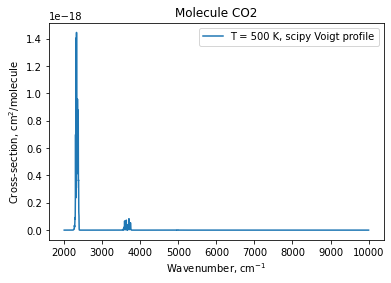

Cross sections plot saved.
Cross sections file saved.


In [249]:
t = Timer()
t.start()
par_filename = par_filepath.split('/')[3]
    
if not os.path.exists:
    raise ImportError('The input file ' + par_filename + ' does not exist.')

# Initialise the iterator object.
iterator = pd.read_csv(par_filepath, chunksize=100_000_000, header=None, encoding='utf-8')
# Depends on how many cores you want to utilise.
# Reserve 64 cores for our script.
max_processors = 64       
pool = multiprocessing.Pool(processes=max_processors)
f_list = []
for parfile_df in iterator:
    f = pool.apply_async(get_results, [parfile_df])
    f_list.append(f)
    if len(f_list) >= max_processors:
        for f in f_list:
            f.get()
            del f_list[:]

t.end()

Q_ref

In [194]:
parfile_df = pd.read_csv(par_filepath, header=None, encoding='utf-8')

In [195]:
hitran_df = read_hitran2016_parfile (par_filepath, parfile_df)
wn_grid, S, Epp, n_air, gamma_air, gamma_self, delta_air, v = hitran_data_prepare(hitran_df)
abscoef = cal_abscoefs(v, S, abundance, Epp, T, T_ref, Q, Q_ref)

In [196]:
alpha = Doppler_HWHM (v, mass, T)
gamma = Lorentzian_HWHM (T, P, n_air, gamma_air, gamma_self, delta_air)

In [235]:
xsec_sv = hitran_cross_section_scipy_Voigt(wn_grid, v, alpha, gamma, abscoef)

xsec_l = hitran_cross_section_Lorentzian(wn_grid, v, gamma, abscoef)

In [246]:
def hitran_cross_section_scipy_Voigt(wn_grid, v, alpha, gamma, abscoef):
    '''
    Read HITRAN .par file as the input file.
    Return the wavennumbers and cross sections with scipy Voigt profile.
    
    '''
    xsec_sv = []
    _xsec_sv = np.zeros_like(wn_grid)

    for i in range(N_point):
        dv = wn_grid[i] - v
        filter_cutoff = np.abs(dv) <=cutoff
        _dv = dv[filter_cutoff]
        _alpha = alpha[filter_cutoff]
        _gamma = gamma[filter_cutoff]
        _abscoef = abscoef[filter_cutoff]
        _xsec_sv = np.sum(_abscoef * scipy_Voigt_profile(_dv, _alpha*2, _gamma*2))

        xsec_sv.append(_xsec_sv)

    return (xsec_sv)

In [241]:
xsec_sv = np.zeros_like(wn_grid)
sv = np.zeros_like(wn_grid)
results = []
x = []
abs = []
for i in range(N_point):
    dv = wn_grid[i] - v
    filter_cutoff = np.abs(dv) <=cutoff
    _dv = dv[filter_cutoff]
    _alpha = alpha[filter_cutoff]
    _gamma = gamma[filter_cutoff]
    _abscoef = abscoef[filter_cutoff]
    sv = scipy_Voigt_profile(_dv, _alpha*2, _gamma*2)
    abs.append(_abscoef)
    results.append(sv)
    x.append(_dv)


In [199]:
results[0]

array([9.51455146e-01, 2.55739797e-01, 1.99632261e-01, 2.03660935e-01,
       1.62609702e-01, 8.05340536e-02, 4.73703770e-02, 4.67585844e-02,
       5.33645627e-02, 4.32581634e-02, 4.17829626e-02, 2.54348931e-02,
       2.83448065e-02, 2.81950280e-02, 3.53986412e-02, 2.34328011e-02,
       1.98197498e-02, 1.45180383e-02, 1.46408205e-02, 1.30319693e-02,
       1.65855103e-02, 1.47083396e-02, 1.10250731e-02, 1.01755295e-02,
       1.13323517e-02, 9.55451603e-03, 9.14887279e-03, 1.04688742e-02,
       9.56321660e-03, 9.69712205e-03, 7.17160392e-03, 5.98852325e-03,
       5.54187223e-03, 6.41647147e-03, 7.00568501e-03, 8.27474369e-03,
       5.12761311e-03, 4.70293679e-03, 4.80300734e-03, 4.46345465e-03,
       5.53237485e-03, 3.91583297e-03, 5.16853382e-03, 3.91998415e-03,
       3.78947695e-03, 2.78002423e-03, 3.13806100e-03, 2.92449720e-03,
       4.00614416e-03, 2.99730613e-03, 3.12130769e-03, 3.11170100e-03,
       2.81488617e-03, 2.84523980e-03, 2.74202433e-03, 3.22927970e-03,
      

In [200]:
len(results[10])

1634

In [201]:
len(x[10])

1634

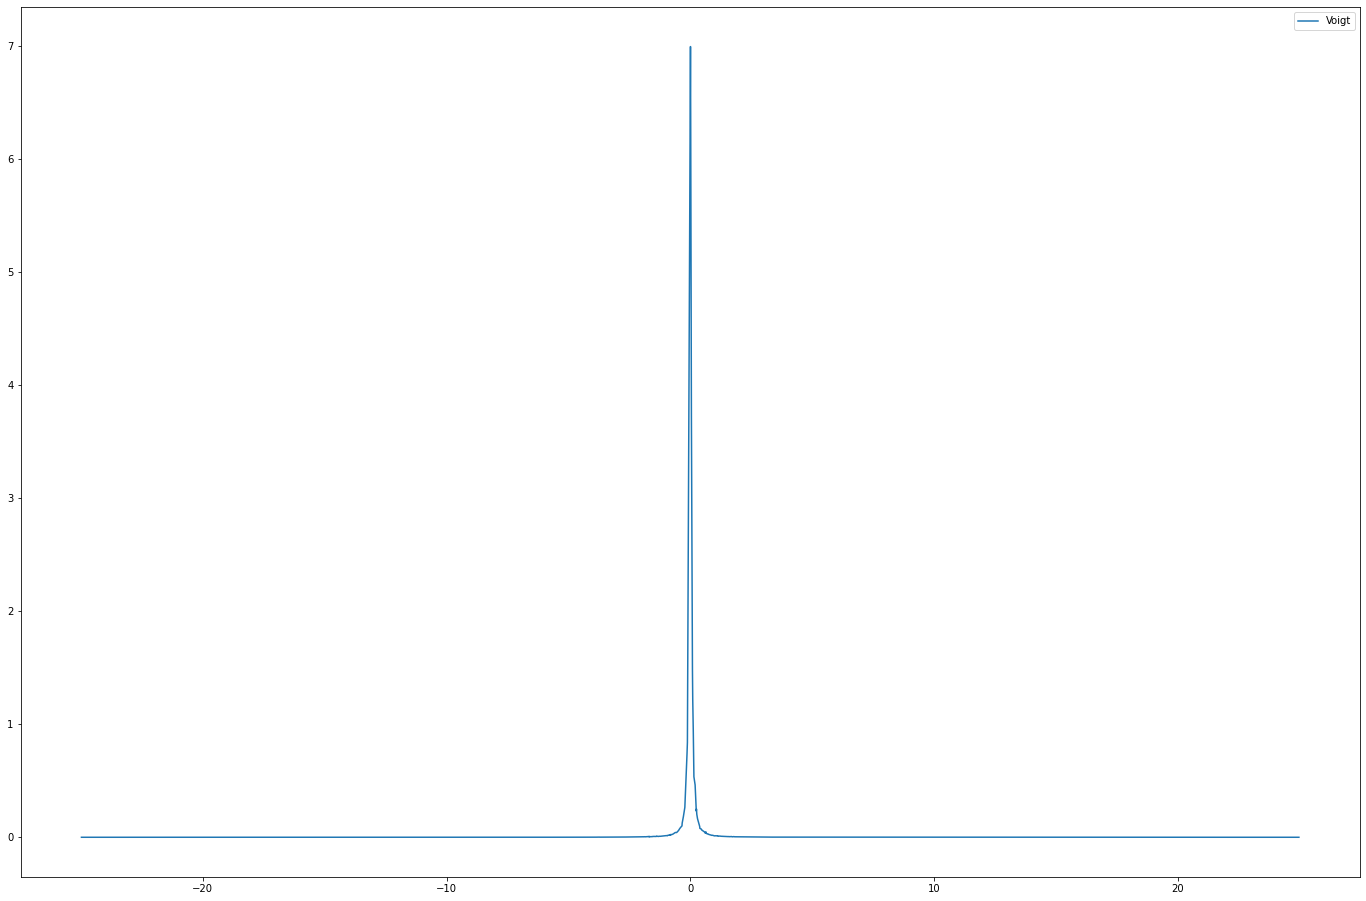

In [202]:
import pylab
n = 8
#alpha, gamma = 0.1, 0.1
fig = plt.figure(figsize = (24, 16))
#pylab.plot(wn_grid, G(x, alpha), ls=':', label='Gaussian')
#pylab.plot(wn_grid, L(x, gamma), ls='--', label='Lorentzian')
pylab.plot(x[n], results[n], label='Voigt')
#pylab.xlim(-0.8,0.8)
pylab.legend()
pylab.show()